In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_validate, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor

In [2]:
data = pd.read_csv(r"/home/winter-storm/f1-data-project/erdos_ds_f1/Patrick/Feature Data Files/final features.csv")

continuous_features_dnf = ['driverExpWeightedSum', 'pitsWeightedSum', 'preRaceALPCWeightedSum', 'TCCAPE', 'clusterMeanWeightedSum',
                           'gapWeightedSum']
categorical_features_dnf = ['topTenDiversity', 'circuitId', 
                            'countryId', 'rain']

dnf_features = continuous_features_dnf + categorical_features_dnf

target = 'totalDNFs'

X_dnf = data[dnf_features]
y = data[target]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_dnf, y, 
                                                    test_size    = 0.2,
                                                    shuffle      = True,
                                                    random_state = 659)

k_fold = KFold(n_splits     = 7,
               shuffle      = True,
               random_state = 659)

In [4]:
gb_regress = HistGradientBoostingRegressor(
    max_iter=100,           # Number of boosting rounds
    learning_rate=0.1,      # Smaller = slower, safer; larger = faster, riskier
    max_depth=None,         # You can tune this; smaller = more regularized
    random_state=42
)

handle_nans = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cont', handle_nans, continuous_features_dnf),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features_dnf)
], remainder="passthrough")

gb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", gb_regress)
])

In [5]:
gb_pipeline.fit(X_train, y_train)
gb_y_pred = gb_pipeline.predict(X_test)

gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)

print(f"Gradient Boosting MSE: {gb_mse:.4f}")
print(f"Gradient Boosting R²: {gb_r2:.4f}")

Gradient Boosting MSE: 6.5715
Gradient Boosting R²: 0.6674


In [6]:
def summarize_cv_results(results, model_name="Model"):
    r2_scores = results['test_r2']
    mse_scores = -results['test_neg_mean_squared_error']  # Convert back to positive MSE

    print(f"\n{model_name} Cross-Validation Summary:")
    print(f"Average R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")

def plot_learning_curve(estimator, X_dnf, y, title="Learning Curve", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_dnf, y, cv=k_fold, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 10),
        shuffle=True, random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training R²')
    plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation R²')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')
    plt.xlabel('Training Set Size')
    plt.ylabel('R² Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Gradient Boosting Cross-Validation Summary:
Average R²: 0.6716 ± 0.0519
Average MSE: 6.3260 ± 0.7875


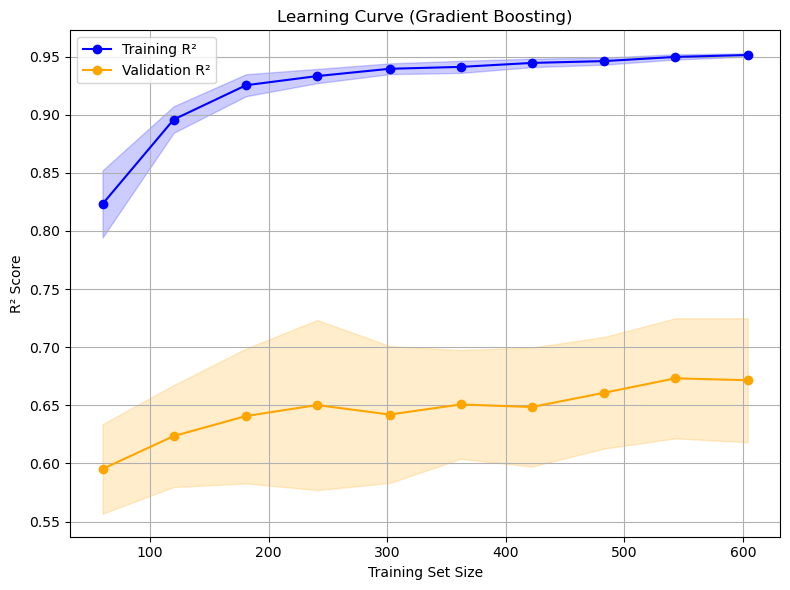

In [7]:
# Cross-validation
gb_cv_results = cross_validate(
    gb_pipeline, X_dnf, y, cv=k_fold,
    scoring=('r2', 'neg_mean_squared_error'),
    return_train_score=True
)

summarize_cv_results(gb_cv_results, "Gradient Boosting")

# Learning curve
plot_learning_curve(gb_pipeline, X_dnf, y, title="Learning Curve (Gradient Boosting)", cv=k_fold)


In [8]:
param_grid = {
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__max_iter': [100, 200],  # This is the correct parameter instead of `n_estimators`
    'regressor__min_samples_leaf': [10, 20],
    'regressor__max_leaf_nodes': [31, 63],  # Optional, to control tree complexity
    'regressor__l2_regularization': [0.0, 0.1, 1.0],  # Optional regularization
}

grid_search = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=param_grid,
    cv=k_fold,                 # your predefined KFold
    scoring='r2',
    n_jobs=-1,                 # use all CPU cores
    verbose=0
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=7, random_state=659, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cont',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['driverExpWeightedSum',
                                                                          'pitsWeightedSum',
                                                                          'preRaceALPCWeightedSum',
                                                                          'TCCAPE',
                                                                          'clusterMeanWeightedSum',
                                                                          'gapWei...
                                                                          'circuitId',
                                                                          'countryId',
                                                                          'rain'])])),
                                       ('regressor',
                                        HistGradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__l2_regularization': [0.0, 0.1, 1.0],
                         'regressor__learning_rate': [0.01, 0.05, 0.1],
                         'regressor__max_depth': [3, 5],
                         'regressor__max_iter': [100, 200],
                         'regressor__max_leaf_nodes': [31, 63],
                         'regressor__min_samples_leaf': [10, 20]},
             scoring='r2')

In [16]:
print("Best parameters found:", grid_search.best_params_)
print("Best CV R² score: {:.4f}".format(grid_search.best_score_))
best_gb_model = grid_search.best_estimator_

best_rf_pred = best_gb_model.predict(X_test)
best_rf_mse = mean_squared_error(y_test, best_rf_pred)
best_rf_r2 = r2_score(y_test, best_rf_pred)

print(f"Test MSE (Best RF): {best_rf_mse:.4f}")
print(f"Test R² (Best RF): {best_rf_r2:.4f}")

Best parameters found: {'regressor__l2_regularization': 1.0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__max_iter': 100, 'regressor__max_leaf_nodes': 31, 'regressor__min_samples_leaf': 20}
Best CV R² score: 0.6947
Test MSE (Best RF): 6.2684
Test R² (Best RF): 0.6827


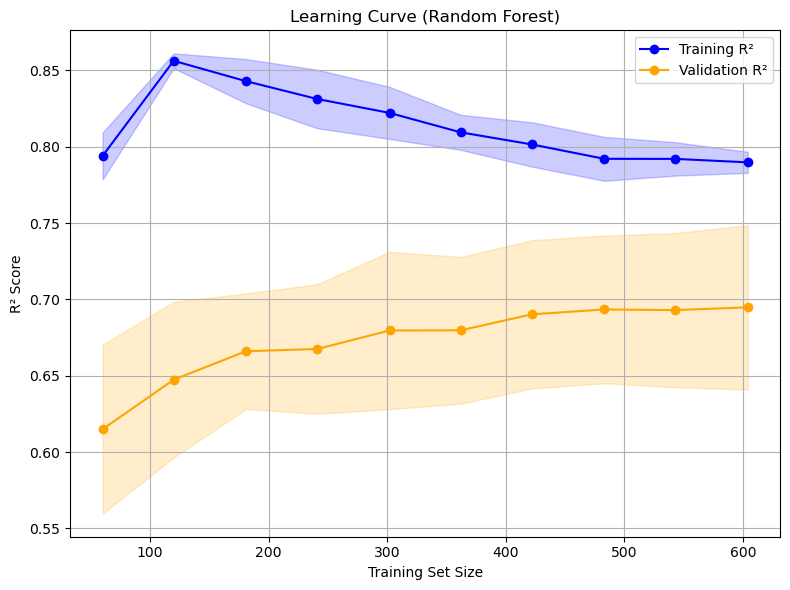

In [ ]:
plot_learning_curve(best_gb_model, X_dnf, y, title="Learning Curve (Gradient Boosting)", cv=k_fold)